In [2]:
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None # supprime certains warnings

In [19]:
X = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/X_train_J01Z4CN.csv")
y = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/y_train_OXxrJt1.csv")
y = y[["price"]] # On ne garde que la colonne price, un supprime la colonne qui porte sur le numéro de l'annonce

X_add_price = X
X_add_price["price"] = y["price"] # création d'un nouveau dataset avec les prix pour d'éventuels traitements

X.head(5)

,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors,price
0,35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,...,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,355000.0
1,35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190000.0
2,35731841,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39000.0
3,35886765,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,217.0,...,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,299000.0
4,35781137,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,NaN,...,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,478000.0


### Etudes des colonnes non numériques

In [4]:
s = (X.dtypes == 'object')    # pour avoir la liste des colonnes avec comme type "objet"
object_cols = list(s[s].index)

# On compte le nombre de valeurs différentes par colonne (pour après faire possiblement du One-Hot Encoding)
nb_val_col = {}
nb_val_manquantes = {}
ratio_val_manquantes = {}
for col in object_cols:
    nb_val_col[col]=[len(X[f"{col}"].value_counts())]
    nb_val_manquantes[col]=X[f"{col}"].isnull().sum() #on compte le nombre de valeurs manquantes pour savoir s'il faut garder la colonne
    ratio_val_manquantes[col]=nb_val_manquantes[col]/len(X[f"{col}"]) #on calcule le ratio de valeurs manquantes

nb_val_col_df = pd.DataFrame(nb_val_col.items(),columns = ["Nom Colonne","Nb de valeurs différentes"])
nb_val_manquantes = pd.DataFrame(nb_val_manquantes.items(),columns = ["Nom Colonne","Nb de valeurs manquantes"])
ratio_val_manquantes = pd.DataFrame(ratio_val_manquantes.items(),columns = ["Nom Colonne","Ratio de valeurs manquantes"])

nb_val_col_df["Nb de valeurs manquantes"]=nb_val_manquantes[["Nb de valeurs manquantes"]]
nb_val_col_df['Ratio de valeurs manquantes']=ratio_val_manquantes[["Ratio de valeurs manquantes"]]

nb_val_col_df

,Nom Colonne,Nb de valeurs différentes,Nb de valeurs manquantes,Ratio de valeurs manquantes
0,property_type,[22],0,0.000000
1,city,[8643],0,0.000000
2,energy_performance_category,[7],18300,0.489724
3,ghg_category,[7],18838,0.504121
4,exposition,[12],28274,0.756637


#### On décie donc de drop les colonnes energy_performance_category, ghg_category et exposition car il manque entre 49% et 76% des valeurs environ

In [20]:
X = X.drop(columns = ["energy_performance_category","ghg_category","exposition"],axis=1)
X.shape

(37368, 25)

### On regarde la corrélation entre les features numériques (en ajoutant le prix dedans)

C:\Users\maila\AppData\Local\Temp\ipykernel_8956\4266196977.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = X_add_price.corr()


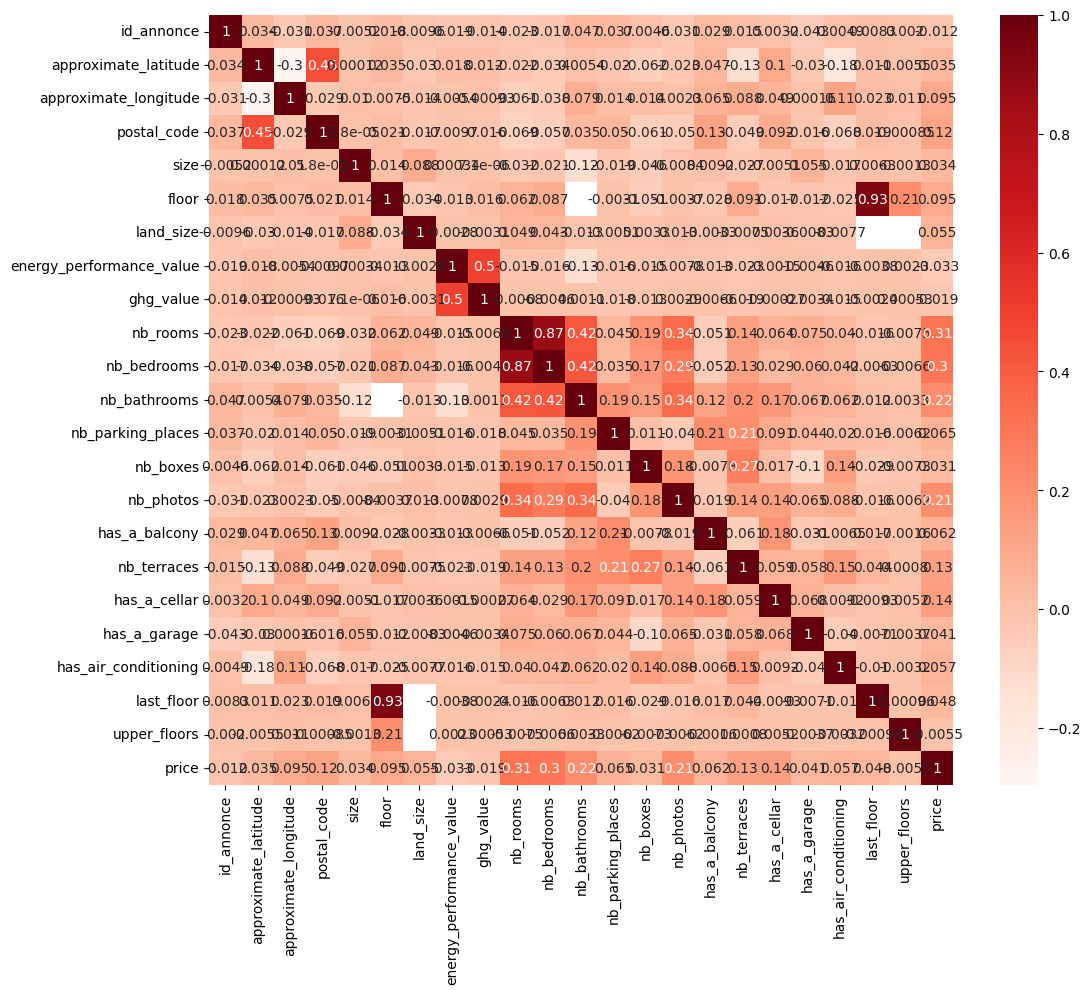

In [55]:
plt.figure(figsize=(12,10))
cor = X_add_price.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### On regarde aussi le score de Mutual Information

In [ ]:
mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

#### On regarde le nomre de valeurs différentes de property_type pour l'encoder ensuite

In [47]:
X["property_type"].value_counts()

appartement          15733
maison               15675
divers                2137
terrain               1534
villa                  781
propriété              408
terrain à bâtir        298
duplex                 220
viager                 177
ferme                  130
parking                 96
loft                    54
chalet                  48
château                 21
moulin                  17
manoir                  15
péniche                  8
hôtel particulier        6
chambre                  4
gîte                     3
atelier                  2
hôtel                    1
Name: property_type, dtype: int64

### Cluster des prix

In [44]:
# création d'un mini dataset avec les coordonnées et le prix pour pouvoir faire un clustering
X_cluster_prix = X[["approximate_latitude", "approximate_longitude"]]
X_cluster_prix["price"]=y[["price"]]

# print(X_cluster_prix.head()) 

kmeans = KMeans(n_clusters=6)
X_cluster_prix["Cluster"] = kmeans.fit_predict(X_cluster_prix)
X_cluster_prix["Cluster"] = X_cluster_prix["Cluster"].astype("category")

X_cluster_prix.head()

,approximate_latitude,approximate_longitude,price,Cluster
0,43.643880,7.117183,355000.0,5
1,45.695757,4.895610,190000.0,1
2,47.966791,-1.220451,39000.0,1
3,47.289292,-1.878805,299000.0,5
4,45.718992,4.844234,478000.0,0


#### Affichage graphique du clustering

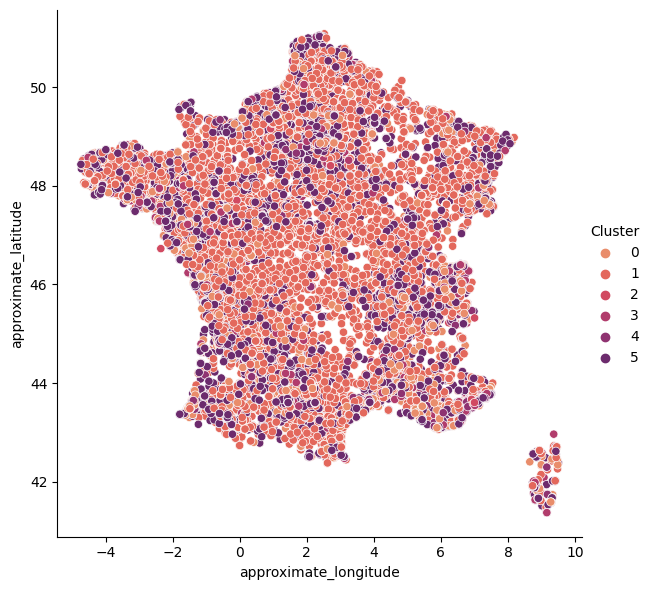

In [45]:
sns.relplot(x="approximate_longitude", y="approximate_latitude", hue = "Cluster", data=X_cluster_prix, height=6, palette = sns.color_palette("flare",n_colors = 6))